# Study of the resulting distributions
In this notebook we want to compare the resulting distributions by applying various statistical methods to quantify differences and similarities.
## Frequencies of Linguistic Elements
To assess the similarity of the resulting distributions, we compute the [*Wasserstein-Metric*](https://en.wikipedia.org/wiki/Wasserstein_metric) of each pair of distributions.
The Wasserstein-Metric is a distance function for probability distributions. It satisfies the criteria of actual mathematical metrics and thus enables comparisons between probability distributions. Assuming one-dimensional distributions, the Wasserstein Distance of two empirical samples $P$ and $Q$ with respective random variables $X_1,...,X_n$ and $Y_1,...,Y_n$ is given by:
$$ W_{p}(P,Q)=\left({\frac {1}{n}}\sum _{i=1}^{n}\|X_{(i)}-Y_{(i)}\|^{p}\right)^{\frac {1}{p}}$$ 
Let's compute the Wasserstein-Metric for the frequencies of Characters, Words, Named Entities and Queries:


In [29]:
from thesis_schneg.vis_modules import _get_results_paths, load_results
import numpy as np

analyses = []
# set analysis that should be analyzed
# analyses.append('query-frequencies')
analyses.append('extract-named-entities')
analyses.append('extract-words')
analyses.append('extract-chars')

# test_data = True
test_data = False

cleaned_aql = True

col = ['count()']

Load Data:

In [30]:
from time import time
# load data
analysis_data = {}
for analysis in analyses:
    print(f"Start loading \"{analysis}\"")
    datasets = {}
    for dataset in ["aol","aql","ms-marco","orcas"]:
        start_time = time()
        paths = _get_results_paths(dataset, analysis, cleaned_aql)
        result_data = load_results(paths, test_data=test_data, cols=col)
        datasets.update({dataset: result_data})
        end_time = time()
        print(f"{dataset.upper()} loaded in {(end_time - start_time)/60} min")
    analysis_data.update({analysis: datasets})

Start loading "extract-named-entities"
AOL loaded in 4.833389596144358 min
aql-extract-named-entities-special
AQL loaded in 0.49013155698776245 min
MS-MARCO loaded in 5.322761690616607 min
ORCAS loaded in 4.106758908430735 min
Start loading "extract-words"
AOL loaded in 0.38442887862523395 min
aql-extract-words-special
AQL loaded in 2.0322048942248028 min
MS-MARCO loaded in 0.34743420680363973 min
ORCAS loaded in 0.37603708505630495 min
Start loading "extract-chars"
AOL loaded in 0.12974830071131388 min
aql-extract-chars-special
AQL loaded in 1.1054505825042724 min
MS-MARCO loaded in 1.233322024345398 min
ORCAS loaded in 0.12964349190394084 min


In [ ]:
from thesis_schneg.vis_modules import get_max_x
threshs = [0.84, 0.957, 0.999]
threshs = [0.99, 0.99, 0.999]

data = analysis_data[analyses[2]]['aql'] 
print(len(data))
x_max = get_max_x(analysis_data[analyses[2]], "count()", rank_sized=True, threshold=0.999)
print(x_max)

for key,val in analysis_data[analyses[2]].items():
    print(key)
    # print(val)
    print(len(val))

    print("---------------")

29975
5045
aol
86
---------------
aql
29975
---------------
ms-marco
14247
---------------
orcas
152
---------------


Compute Wasserstein-Distances:

In [31]:
from thesis_schneg.vis_modules import get_max_x
from numpy import ndarray
from pandas import DataFrame
from scipy.stats import wasserstein_distance_nd

# we choose thresholds so that the aqls elemntes are aligned with the highest number of elements present in the other datasets
threshs = [0.84, 0.957, 0.999]
# threshs = [0.99, 0.99, 0.999]

cnt=0
distances_data = {}
for analysis, datasets in analysis_data.items():
    print(analysis)
    x_max = get_max_x(datasets, "count()", rank_sized=True, threshold=threshs[cnt])
    print(x_max)
    # distances = ndarray((len(datasets), len(datasets)))
    distances = DataFrame(np.zeros((len(datasets), len(datasets))), index=datasets.keys(), columns=datasets.keys())
    names = []
    j=0
    for dataset_name, data in datasets.items():
        data1 = data.sort_values("count()", ascending=False)/data['count()'].sum()
        # print(data1["count()"].iloc[0:3])
        # print(data1["count()"].iloc[-3:-1])

        # data1 = data.sort_values("count()", ascending=True)
        names.append(dataset_name)
        x_vals = np.arange(1, x_max+1)
        y_vals = data1['count()'][0:x_max].to_numpy()
        # 
        if len(y_vals) < x_max:
            y_vals = np.append(y_vals, np.zeros(x_max-len(y_vals)))
        i=0
        for dataset_name, data in datasets.items():
            if dataset_name in names:
                dist = 0
            else:
                data2 = data.sort_values("count()", ascending=False)/data['count()'].sum()
                # data2 = data.sort_values("count()", ascending=True)
                x_vals2 = np.arange(1, x_max+1)
                y_vals2 = data2['count()'][0:x_max].to_numpy()
                if len(y_vals2) < x_max:
                    y_vals2 = np.append(y_vals2, np.zeros(x_max-len(y_vals2)))
                dist = wasserstein_distance_nd(x_vals, x_vals2, u_weights=y_vals, v_weights=y_vals2)
            # distances[i][j] = dist
            distances.iloc[i, j] = dist
            i+=1
        j+=1
    distances = distances + distances.T
    distances_data.update({analysis: distances})
    cnt+=1
for key, value in distances_data.items():
    print(value)

## get avarage wasserstein distances per query log
avg_distances = {}
for analysis, distances in distances_data.items():
    avg_distances.update({analysis: distances.mean().mean()})
    
for key, value in avg_distances.items():
    print(key, value)

extract-named-entities
2234823
extract-words
4306754
extract-chars
5045
                    aol            aql       ms-marco          orcas
aol            0.000000   91895.269206  391408.370509   27423.561203
aql        91895.269206       0.000000  301466.786330   97748.775165
ms-marco  391408.370509  301466.786330       0.000000  397262.426016
orcas      27423.561203   97748.775165  397262.426016       0.000000
                    aol            aql       ms-marco          orcas
aol            0.000000   55120.504012  216678.052998   77063.912340
aql        55120.504012       0.000000  161679.303762  132184.397833
ms-marco  216678.052998  161679.303762       0.000000  293741.965337
orcas      77063.912340  132184.397833  293741.965337       0.000000
                aol        aql   ms-marco      orcas
aol        0.000000  56.752878  91.766412   0.516278
aql       56.752878   0.000000  43.967795  57.148811
ms-marco  91.766412  43.967795   0.000000  92.162345
orcas      0.516278  57.14

In [ ]:
# compute average distance within AOL, MS-MARCO, ORCAS,
# compute average distance between AQL and the other datasets
# compute difference between the average distance of AQL and the average distance of the other datasets
# compute std of the distances within comparison group
# express difference in std
def get_ws_stats(distancedata):
    ws_stats = {}
    for analysis, distances in distancedata.items():
        # get distances of AOL, MS MARCO, ORCAS
        aol = distances.loc['aol'].to_numpy()
        # print(aol)
        ms_marco = distances.loc['ms-marco'].to_numpy()
        # get distances of AQL
        aql = distances.loc['aql'].to_numpy()
        # print(aol,aql,ms_marco,orcas,sep='\n')
        aql_dist = aql.sum()/3
        notaql_dist = (aol[2]+aol[3]+ms_marco[3])/3
        std = np.std([aol[2], aol[3], ms_marco[3]])
        aql_dist_deviation = notaql_dist - aql_dist
        aql_distinSTD = aql_dist_deviation/std
        ws_stats.update({analysis: [notaql_dist, aql_dist, aql_dist_deviation, std, aql_distinSTD]})
    return ws_stats
        
for key, value in get_ws_stats(distances_data).items():
    print(key, value)

extract-named-entities [163703.61023350118, 272031.45257597807, -108327.84234247688, 172980.40906981862, -0.6262434163787498]
extract-words [116328.06853591518, 195827.97689153315, -79499.90835561797, 89678.64449589721, -0.8864976584169387]
extract-chars [52.62316160680013, 61.48167817797205, -8.858516571171918, 43.10935104095988, -0.2054894438739079]


Visualize results in Wasserstein Space:

In [43]:
from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity='precomputed')
trans_dists = {}
for key, value in distances_data.items():
    print(key)
    trans_dists.update({key: mds.fit_transform(value)})

extract-named-entities
extract-words
extract-chars


['Entitis ranked', 'Words ranked', 'Chars ranked']


/tmp/ipykernel_150824/1247892468.py:126: UserWarning: linewidths is ignored by contourf
  ax.contourf(X.astype(float), Y.astype(float), Z.astype(float), 10, alpha=0.7, cmap = 'Blues', linewidths=0.5, linestyles='solid') #, cmap='Blues' 'OrRd'


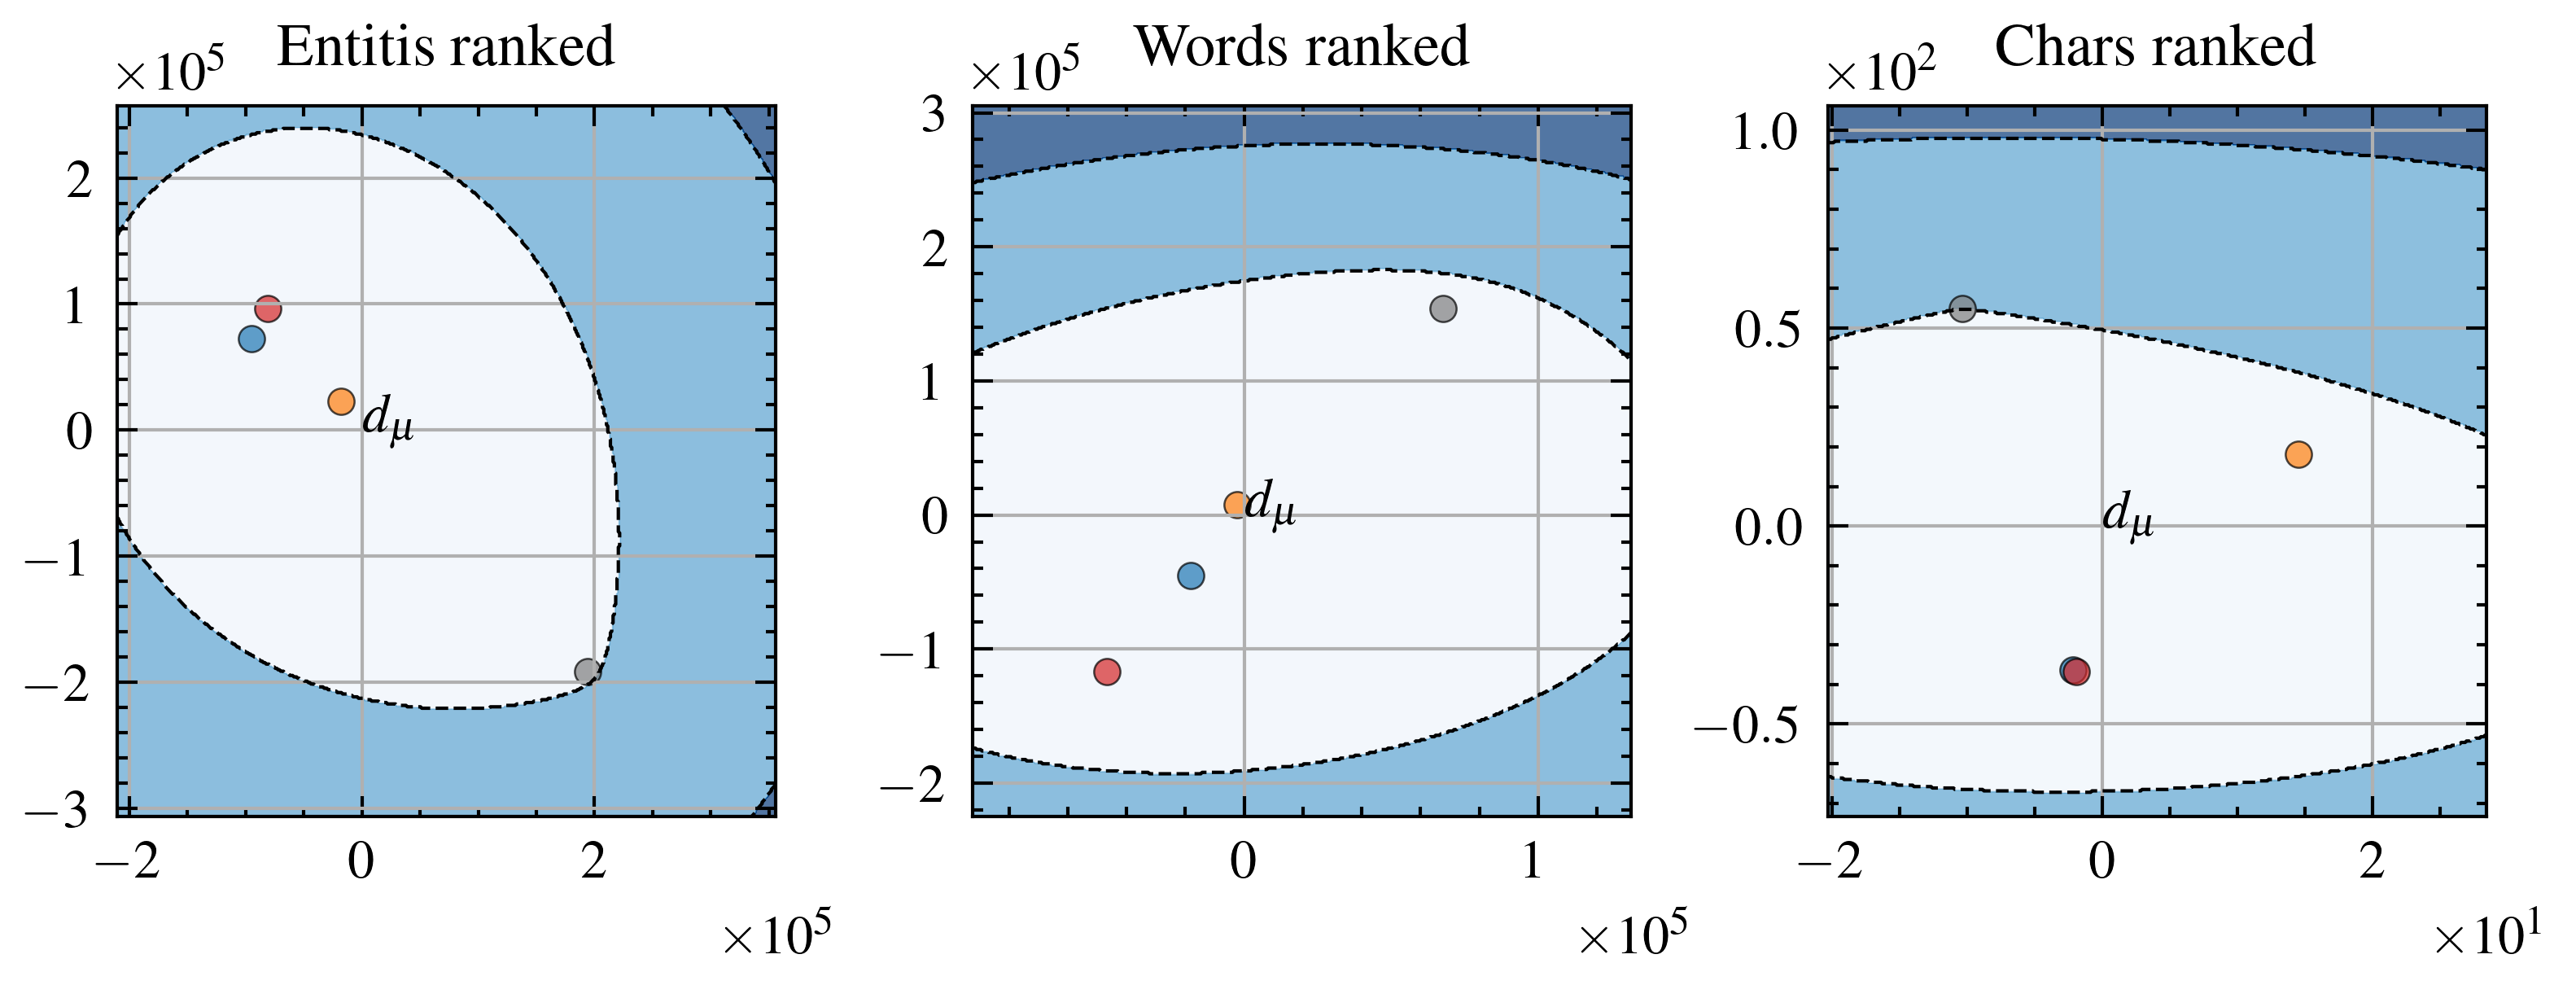

In [45]:
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
from pathlib import Path    
import scienceplots

def avg_dist_notAQL(x,y, point_matrtix):
    dist = 0
    for i in range(len(point_matrtix)):
        if i != 1:
            dist += np.sqrt((x - point_matrtix[i][0])**2 + (y - point_matrtix[i][1])**2)
    dist = dist/3
    # return dist
    # # get the average distance of the points within AOL, ORCAS, MS-MARCO Web Search    
    avg_dist_within = 0
    for i in [(0,2), (0,3), (2,3)]:
        avg_dist_within += np.sqrt((point_matrtix[i[0]][0] - point_matrtix[i[1]][0])**2 + (point_matrtix[i[0]][1] - point_matrtix[i[1]][1])**2)
    avg_dist_within = avg_dist_within/3

    # get the standard deviation of distances within AOL, ORCAS, MS-MARCO Web Search
    std_dist_within = 0
    for i in [(0,2), (0,3), (2,3)]:
        std_dist_within += (np.sqrt((point_matrtix[i[0]][0] - point_matrtix[i[1]][0])**2 + (point_matrtix[i[0]][1] - point_matrtix[i[1]][1])**2) - avg_dist_within)**2
    std_dist_within = np.sqrt(std_dist_within/3) 

    if dist <= avg_dist_within:
        return avg_dist_within
    elif dist > avg_dist_within and dist <= avg_dist_within + std_dist_within:
        return avg_dist_within + std_dist_within
    elif dist > avg_dist_within + std_dist_within and dist <= avg_dist_within + 2 * std_dist_within:
        return avg_dist_within + 2 * std_dist_within
    elif dist > avg_dist_within + 2 * std_dist_within and dist <= avg_dist_within + 3 * std_dist_within:
        return avg_dist_within + 3 * std_dist_within
    elif dist > avg_dist_within + 3 * std_dist_within and dist <= avg_dist_within + 4 * std_dist_within:
        return avg_dist_within + 4 * std_dist_within
    elif dist > avg_dist_within + 4 * std_dist_within and dist <= avg_dist_within + 5 * std_dist_within:
        return avg_dist_within + 5 * std_dist_within
    else: 
        return avg_dist_within + 6 * std_dist_within
        
def avg_dist_within(points):
    dist = 0
    pairs = [(0, 2), (0, 3), (2, 3)]  # Indizes der Punkte AOL, MS-MARCO, ORCAS
    for i, j in pairs:
        dist += np.sqrt((points[i][0] - points[j][0])**2 + (points[i][1] - points[j][1])**2)
    return dist / len(pairs)
def std_within(points):
    dist = 0
    pairs = [(0, 2), (0, 3), (2, 3)]  # Indizes der Punkte AOL, MS-MARCO, ORCAS
    for i, j in pairs:
        dist += (np.sqrt((points[i][0] - points[j][0])**2 + (points[i][1] - points[j][1])**2) - avg_dist_within(points))**2
    return np.sqrt(dist / len(pairs))

# use science style for plots from scienceplots library
plt.style.use(["science", "ieee"])
color =  ['tab:blue', 'tab:orange', 'tab:gray', 'tab:red']

save_vis = True
# save_vis = False
# plot_legend = True
plot_legend = False

# get meshsize
# mesh_size = 70
mesh_size = 500

num_plots = len(trans_dists)
cols = 3
rows = num_plots//cols
if num_plots % cols != 0:
    rows+=1

textwidth = 5.5129
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale *1.1
height = width * aspect_ratio * 0.40


fig,ax = plt.subplots(rows,cols, figsize=(width,height))


# for making the titles
keys = [key for key in trans_dists.keys()]
# Dynamically generate titles for each plot
titles = [f"{key.split('-')[-1].title()} in {key.split('-')[0].title()}s" for key in keys]
# Adjust titles for specific cases (e.g., "Entities" instead of "Entitys")
titles = ["Entitis ranked", "Words ranked", "Chars ranked"]
print(titles)

positions = [[0.0,0.0], [1.0,0.0], [0.0,0.0]]


axes = ax.flatten()
for i in range(len(trans_dists)):
    ax = axes[i]
    ax.set_title(titles[i], fontsize=9)

    points = trans_dists[keys[i]]

    # get the highes and lowest x and y values of the points
    x_min = np.min(points[:,0])
    x_max = np.max(points[:,0])
    y_min = np.min(points[:,1])
    y_max = np.max(points[:,1])

    # scale the extreme values of x and y to get a good boundary for the plot
    # we take the scale of the min range
    range_scale = 0.4
    x_min = x_min - range_scale * (x_max - x_min)
    x_max = x_max + range_scale * (x_max - x_min)
    y_min = y_min - range_scale * (y_max - y_min)
    y_max = y_max + range_scale * (y_max - y_min)

    x = np.linspace(x_min, x_max, mesh_size)
    y = np.linspace(y_min, y_max, mesh_size)

    z = np.array([avg_dist_notAQL(i,j,points) for j in y for i in x])


    X, Y = np.meshgrid(x, y)
    Z = z.reshape(mesh_size, mesh_size)

    avg_dist = avg_dist_within(points)
    std_dist = std_within(points)

    ax.contourf(X.astype(float), Y.astype(float), Z.astype(float), 10, alpha=0.7, cmap = 'Blues', linewidths=0.5, linestyles='solid') #, cmap='Blues' 'OrRd'
    # Add contour lines for the average distance within AOL, MS-MARCO, and ORCAS and the standard deviation 
    contour = ax.contour(X.astype(float), Y.astype(float), Z.astype(float), levels=[avg_dist, avg_dist+std_dist, avg_dist+2*std_dist, avg_dist+3*std_dist, avg_dist+4*std_dist, avg_dist+5*std_dist], colors='black', linewidths=0.5, linestyles='dashed')

    # Label the contour lines with descriptive text
    text = ["$d_{{\mu}}$", "$d_{{\mu}} + \sigma$", "$d_{{\mu}} + 2 \sigma$"]
    for j, level in enumerate(contour.levels):
        # Find the position for the label (e.g., the midpoint of the contour line)
        idx = np.where(Z == level)
        if len(idx[0]) > 0:
            if j == 0:
                x_pos = positions[i][0] 
                y_pos = positions[i][1]
                ax.text(x_pos, y_pos, text[j] , fontsize=8, color='black')

    labels = [name.upper() for name in names]
    labels[2] = "MS-MARCO WS"
    # plot 3d scatter plot
    for j in range(len(points)):
        ax.scatter(points[j][0], points[j][1], c=color[j], label=labels[j], s=15, edgecolor='black', linewidth=0.3, alpha=0.7)

    ax.grid(True)
    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    ax.xaxis.offsetText.set_x(1.1)  # Verschiebt den Exponenten horizontal
    ax.xaxis.offsetText.set_y(-0.9)  # Verschiebt den Exponenten vertikal
    
if plot_legend:
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.04), fancybox=False, ncol=len(names),edgecolor="black", frameon=True).get_frame().set_linewidth(0.5)

plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.4, wspace=0.3)
plt.show()

base_path = "/home/benjamin/studium/masterarbeit/thesis-schneg/plots/"
if plot_legend:
    vis_dir = Path(f"{base_path}Wasserstein-Distances-elements-2d-contour")
else:
    vis_dir = Path(f"{base_path}Wasserstein-Distances-elements-2d-contour-no-legend")
if not vis_dir.exists() and save_vis:
        vis_dir.mkdir(parents=True)

if not vis_dir.exists() and save_vis:
        vis_dir.mkdir(parents=True)

if save_vis:
    fig.savefig(vis_dir.joinpath("all.pdf"), format='pdf')

## Length-related Frequencies
### 1. Kolmogerov-Smirnov-Test
First of all, we carry out a statistical test to check if the different distributions result from a common underlying distribution. We select the [*Kolmogerov-Smirnov-Test*](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#Two-sample_Kolmogorov.E2.80.93Smirnov_test) to verify this hypothesis.  

The test computes a test statistic $D$ that is compared to a threshold $D_{\alpha}$ with a significance level $\alpha$. If
$$D < D_{\alpha}$$ 
then the two distributions are likely to be similar. If, in contrast, 
$$D \ge D_{\alpha}$$ 
then we can conclude the samples are not from a common distribution with a significance of $1-\alpha$. The test measures the maximum distance of the cumulative distribution functions $F$ of the involved distributions. Accordingly, $D$ is computed by
$$D = \mathrm{max} |( F_{1} - F_{2} )| $$
The threshold can be determined by 
$$D_{\alpha} = K_{\alpha}\sqrt{(n_1+n_2)/(n_1 \cdot n_2)} $$
$K_{\alpha}$ is a constant that is dependent on the significance level $\alpha$ and can be obtained by this table:


![image.png](attachment:image.png)

In [1]:
from thesis_schneg.model import DatasetName

##### set visualization configuration #####



# select dataset (if none is selected all datasets are visualized in a joint plot) 
dataset: DatasetName = None 
# dataset: DatasetName = 'aol'
# dataset: DatasetName = 'aql'
# dataset: DatasetName = 'ms-marco'
# dataset: DatasetName = 'orcas'

# plot cleaned aol data or not
cleaned_aol = False
# cleaned_aol = True

struc_level = []
struc_level.append('queries')
struc_level.append('named-entities')
struc_level.append('words')

base_analyses = []
base_analyses.append('character-count-frequencies') #-{struc}
base_analyses.append('word-count-frequencies')
base_analyses.append('entity-count-frequencies')

analyses = []
for item in base_analyses:
    for struc in struc_level:
        if item == 'word-count-frequencies' and struc != 'words':
            analyses.append(f'{item}-{struc}')
        elif item == 'entity-count-frequencies' and struc != 'named-entities' and struc != 'words':
            analyses.append(f'{item}-{struc}')
        elif item == 'character-count-frequencies':
            analyses.append(f'{item}-{struc}')

# test_data = True
test_data = False

normalize_data = True
# normalize_data = False


In [2]:
from thesis_schneg.vis_modules import _get_results_paths, load_results
from pathlib import Path
import time
color = None
label = None
# load data
analysis_data = []
for analysis_name in analyses:
    if dataset is None:
        result_data = {}
        # crawl files from all datasets and load into dictionary
        paths = {f"{name}": _get_results_paths(name, analysis_name, cleaned_aql=True) for name in [
            "aol", "aql", "ms-marco", "orcas"]}
        if analysis_name == 'character-count-frequencies-words' and cleaned_aol:
            base_path = Path("/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/analysis_data/analysis/aol-words-character-count-frequencies-special")
            paths["aol"] = [path for path in base_path.iterdir(
        )]
        if analysis_name == 'character-count-frequencies-queries':
            base_path = Path("/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/analysis_data/analysis/aql-get-char-count-special")
            paths["aql"] = [path for path in base_path.iterdir(
        )]
            
        for name, result_paths in paths.items():
            start_time = time.time()
            print(f"Loading data from {name} dataset")
            vis_data = load_results(result_paths, test_data=test_data)
            result_data.update({name: vis_data})
            end_time = time.time()  
            print(f"{name} loaded in {(end_time - start_time)/60} min")

        analysis_data.append(result_data)
    else:
        # load data from single dataset
        result_paths = _get_results_paths(dataset, analysis_name, cleaned_aql=True)
        if analysis_name == 'character-count-frequencies-words' and cleaned_aol:
            base_path = Path("/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/analysis_data/analysis/aol-words-character-count-frequencies-special")
            result_paths = [path for path in base_path.iterdir(
        )]
        start_time = time.time()
        print(f"Loading data from {dataset} dataset")
        result_data = {dataset: load_results(result_paths)}
        end_time = time.time()  
        print(f"{dataset} loaded in {(end_time - start_time)/60} min")
        analysis_data.append(result_data)   

/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/analysis_data/analysis/aql-character-count-frequencies-queries-special
Loading data from aol dataset
aol loaded in 0.23538933595021566 min
Loading data from aql dataset
aql loaded in 0.37209360202153524 min
Loading data from ms-marco dataset
ms-marco loaded in 0.17004571755727133 min
Loading data from orcas dataset
orcas loaded in 0.17229437430699665 min
/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/analysis_data/analysis/aql-character-count-frequencies-named-entities-special
Loading data from aol dataset
aol loaded in 0.10616446733474731 min
Loading data from aql dataset
aql loaded in 0.2245997707049052 min
Loading data from ms-marco dataset
ms-marco loaded in 0.11634835799535116 min
Loading data from orcas dataset
orcas loaded in 0.09977917273839315 min
/mnt/ceph/storage/data-in-progress/data-teaching/theses/thesis-schneg/analysis_data/analysis/aql-character-count-frequencies-words-special
L

In [ ]:
from thesis_schneg.vis_modules import ks_test, chi2_fit

cnt = 0
for analysis in analysis_data:
    print(analyses[cnt])
    test_data = analysis['aql']
    test_counts = []
    if 'character-count' in test_data.columns:
        # print("character-count")
        test_data = test_data.query('`character-count` > 0')
        test_data = test_data.query('`character-count` < 50').sort_values('character-count', ascending=True)
        test_data = test_data['count()'].to_numpy()
        col = 'character-count'
        max = 50
    elif 'entity-count' in test_data.columns: 
        # print("entity-count")
        test_data = test_data.query('`entity-count` >= 0')
        test_data = test_data.query('`entity-count` < 3').sort_values('entity-count', ascending=True)
        test_data = test_data['count()'].to_numpy()
        col = 'entity-count'
        max = 3
    elif 'word-count' in test_data.columns:
        # print("word-count")
        test_data = test_data.query('`word-count` > 0')
        test_data = test_data.query('`word-count` < 8').sort_values('word-count', ascending=True)
        test_data = test_data['count()'].to_numpy()  
        col = 'word-count'
        max = 8
    # print(f"max: {max}")
    for dataset, data in analysis.items():
        if dataset != 'aql':
            exp_counts = []
            if col == 'entity-count':
                exp_data = data.query(f"`{col}` >= 0")
            else:
                exp_data = data.query(f"`{col}` > 0")
            exp_data = exp_data.query(f'`{col}` < {max}').sort_values(col, ascending=True)
            exp_data = exp_data['count()'].to_numpy()
            
            test_statistic, threshold, test_res = ks_test(test_data, exp_data, significance_lvl=0.05)
            print(f"Test AQL vs {dataset.upper()}: ks-test-statistic: {test_statistic} threshold: {threshold} common distribution: {test_res}")
            test_statistic, threshold, test_res = chi2_fit(test_data, exp_data, significance_lvl=0.05)
            print(f"Test AQL vs {dataset.upper()}: chi2-test-statistic: {test_statistic} threshold: {threshold} common distribution: {test_res}")

    

    cnt+=1

character-count-frequencies-queries
Test AQL vs AOL: ks-test-statistic: 0.11173531961695468 threshold: 0.00024166922498427152 common distribution: False
Test AQL vs AOL: chi2-test-statistic: 65750470.63159055 threshold: 65.17076890356984 common distribution: False
Test AQL vs MS-MARCO: ks-test-statistic: 0.12681904097342817 threshold: 0.0004602167429355898 common distribution: False
Test AQL vs MS-MARCO: chi2-test-statistic: 308275880.3753942 threshold: 65.17076890356984 common distribution: False
Test AQL vs ORCAS: ks-test-statistic: 0.2631041848885969 threshold: 0.000430322838737808 common distribution: False
Test AQL vs ORCAS: chi2-test-statistic: 4828928069.247391 threshold: 65.17076890356984 common distribution: False
character-count-frequencies-named-entities
Test AQL vs AOL: ks-test-statistic: 0.08229342045206064 threshold: 0.0012005150337576981 common distribution: False
Test AQL vs AOL: chi2-test-statistic: 2019180.2128319456 threshold: 65.17076890356984 common distribution: F

### 2. Wasserstein Metric
As we can see, the test clearly rejects the distributions being from the same underlying distribution. However, visualizations of the distributions showed that there are similarities. To assess, if the AQL's queries suit to the other realistic query logs, we measure distances between the distributions by computing the Wasserstein Metric.

In [46]:
from thesis_schneg.model import DatasetName
from thesis_schneg.vis_modules import _get_results_paths, load_results
from pyarrow import compute as pc
import numpy as np

struc_level = []
struc_level.append('queries')
struc_level.append('named-Entities')
struc_level.append('words')

base_analyses = []
base_analyses.append('character-count') #-{struc}
base_analyses.append('word-count')
base_analyses.append('entity-count')

analyses = []
for item in base_analyses:
    for struc in struc_level:
        analyses.append(f'{item.lower()}-frequencies-{struc.lower()}')
    del struc_level[-1]

cleaned_aql = True

Load data:

In [47]:
from time import time
# load data
analysis_data = {}
for analysis in analyses:
    print(f"Start loading \"{analysis}\"")
    datasets = {}
    for dataset in ["aol","aql","ms-marco","orcas"]:
        start_time = time()
        paths = _get_results_paths(dataset, analysis, cleaned_aql)
        result_data = load_results(paths)
        datasets.update({dataset: result_data})
        end_time = time()
        print(f"{dataset.upper()} loaded in {(end_time - start_time)/60} min")
    analysis_data.update({analysis: datasets})

Start loading "character-count-frequencies-queries"
AOL loaded in 0.29226355950037636 min
aql-character-count-frequencies-queries-special
AQL loaded in 0.35234424273173015 min
MS-MARCO loaded in 0.22233450412750244 min
ORCAS loaded in 0.1263052225112915 min
Start loading "character-count-frequencies-named-entities"
AOL loaded in 0.10279342333475748 min
aql-character-count-frequencies-named-entities-special
AQL loaded in 0.2029607097307841 min
MS-MARCO loaded in 0.14944992462793985 min
ORCAS loaded in 0.08527619441350301 min
Start loading "character-count-frequencies-words"
AOL loaded in 0.075258735815684 min
aql-character-count-frequencies-words-special
AQL loaded in 0.13534316619237263 min
MS-MARCO loaded in 0.0590493639310201 min
ORCAS loaded in 0.05125341018040975 min
Start loading "word-count-frequencies-queries"
AOL loaded in 0.028944178422292074 min
aql-word-count-frequencies-queries-special
AQL loaded in 0.15876404444376627 min
MS-MARCO loaded in 0.03700855573018392 min
ORCAS lo

Compute Wasserstein Distances:

In [48]:
from thesis_schneg.vis_modules import get_max_x
from numpy import ndarray
from pandas import DataFrame
from scipy.stats import wasserstein_distance_nd

cnt=0
distances_data = {}


for analysis, datasets in analysis_data.items():
    x_max = get_max_x(datasets, f"{analysis.split('-')[0]}-count")
    distances = DataFrame(np.zeros((len(datasets), len(datasets))), index=datasets.keys(), columns=datasets.keys())
    
    names = []
    j=0
    for dataset_name, data in datasets.items():
        data1 = {dataset_name: data.sort_values(f"{analysis.split('-')[0]}-count", ascending=True)}
        names.append(dataset_name)
        x_vals = data1[dataset_name][f"{analysis.split('-')[0]}-count"][0:x_max]
        y_vals = data1[dataset_name]['count()'][0:x_max]
        i=0
        for dataset_name, data in datasets.items():
            if dataset_name in names:
                dist = 0
            else:
                data2 = data.sort_values(f"{analysis.split('-')[0]}-count", ascending=True)
                x_vals2 = data2[f"{analysis.split('-')[0]}-count"][0:x_max]
                y_vals2 = data2['count()'][0:x_max]
                dist = wasserstein_distance_nd(x_vals, x_vals2, u_weights=y_vals, v_weights=y_vals2)

            distances.iloc[i, j] = round(dist,2)

            i+=1
        j+=1
    distances = distances + distances.T
    distances_data.update({analysis: distances})
    cnt+=1
# for key, value in distances_data.items():
#     print(key)
#     print(value)

## get avarage wasserstein distances in comparison group and of aql
# avg_distances = {}
for analysis, distances in distances_data.items():
    aql_avg = distances['aql'].sum()/3
    print(f"AQLavg = {aql_avg}")
    notaql_avg = (distances['aol'][2:3].sum() + distances['ms-marco'][3].sum())/3
    print(f"notAQLavg = {notaql_avg}")

    
    # get average wasserstein distances per query log
    avg_distances = {}
    avg_distances.update({analysis: distances.mean()})
    
for key, value in avg_distances.items():
    print(key, value)

# get standard

AQLavg = 6.013333333333333
notAQLavg = 1.8533333333333335
AQLavg = 2.3200000000000003
notAQLavg = 0.9400000000000001
AQLavg = 4.716666666666667
notAQLavg = 2.8366666666666664
AQLavg = 0.88
notAQLavg = 0.37666666666666665
AQLavg = 0.2233333333333333
notAQLavg = 0.07666666666666667
AQLavg = 0.13
notAQLavg = 0.06999999999999999
entity-count-frequencies-queries aol         0.0825
aql         0.0975
ms-marco    0.0675
orcas       0.0675
dtype: float64


/tmp/ipykernel_150824/2515257352.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  notaql_avg = (distances['aol'][2:3].sum() + distances['ms-marco'][3].sum())/3


In [11]:
# compute average distance within AOL, MS-MARCO, ORCAS,
# compute average distance between AQL and the other datasets
# compute difference between the average distance of AQL and the average distance of the other datasets
# compute std of the distances within comparison group
# express difference in std
def get_ws_stats(distancedata):
    ws_stats = {}
    for analysis, distances in distancedata.items():
        # get distances of AOL, MS MARCO, ORCAS
        aol = distances.loc['aol'].to_numpy()
        # print(aol)
        ms_marco = distances.loc['ms-marco'].to_numpy()
        # get distances of AQL
        aql = distances.loc['aql'].to_numpy()
        # print(aol,aql,ms_marco,orcas,sep='\n')
        aql_dist = aql.sum()/3
        notaql_dist = (aol[2]+aol[3]+ms_marco[3])/3
        std = np.std([aol[2], aol[3], ms_marco[3]])
        aql_dist_deviation = notaql_dist - aql_dist
        aql_distinSTD = aql_dist_deviation/std
        ws_stats.update({analysis: [notaql_dist, aql_dist, aql_dist_deviation, std, aql_distinSTD]})
    return ws_stats
        
for key, value in get_ws_stats(distances_data).items():
    print(key, value)

character-count-frequencies-queries [3.0933333333333337, 6.013333333333333, -2.919999999999999, 0.4781445620544296, -6.106939682538104]
character-count-frequencies-named-entities [1.2066666666666668, 2.3200000000000003, -1.1133333333333335, 0.42303138838099896, -2.631798405300888]
character-count-frequencies-words [4.236666666666667, 4.716666666666667, -0.47999999999999954, 1.6781007783271604, -0.2860376481551332]
word-count-frequencies-queries [0.6733333333333333, 0.88, -0.20666666666666667, 0.18408935028645435, -1.1226432509272297]
word-count-frequencies-named-entities [0.11333333333333333, 0.2233333333333333, -0.10999999999999997, 0.044969125210773474, -2.446122744981633]
entity-count-frequencies-queries [0.08, 0.13, -0.05, 0.03741657386773942, -1.3363062095621219]


Since we have 4 distances for each characteristic, we can display a configuration of points in the three-dimensional space that fully reflects the distances:

In [49]:
from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity='precomputed')
trans_dists = {}
for key, value in distances_data.items():
    print(key)
    trans_dists.update({key: mds.fit_transform(value)})

character-count-frequencies-queries
character-count-frequencies-named-entities
character-count-frequencies-words
word-count-frequencies-queries
word-count-frequencies-named-entities
entity-count-frequencies-queries


/tmp/ipykernel_150824/421519227.py:121: UserWarning: linewidths is ignored by contourf
  ax.contourf(X.astype(float), Y.astype(float), Z.astype(float), 10, alpha=0.7, cmap = 'Blues', linewidths=0.5, linestyles='solid') #, cmap='Blues' 'OrRd'


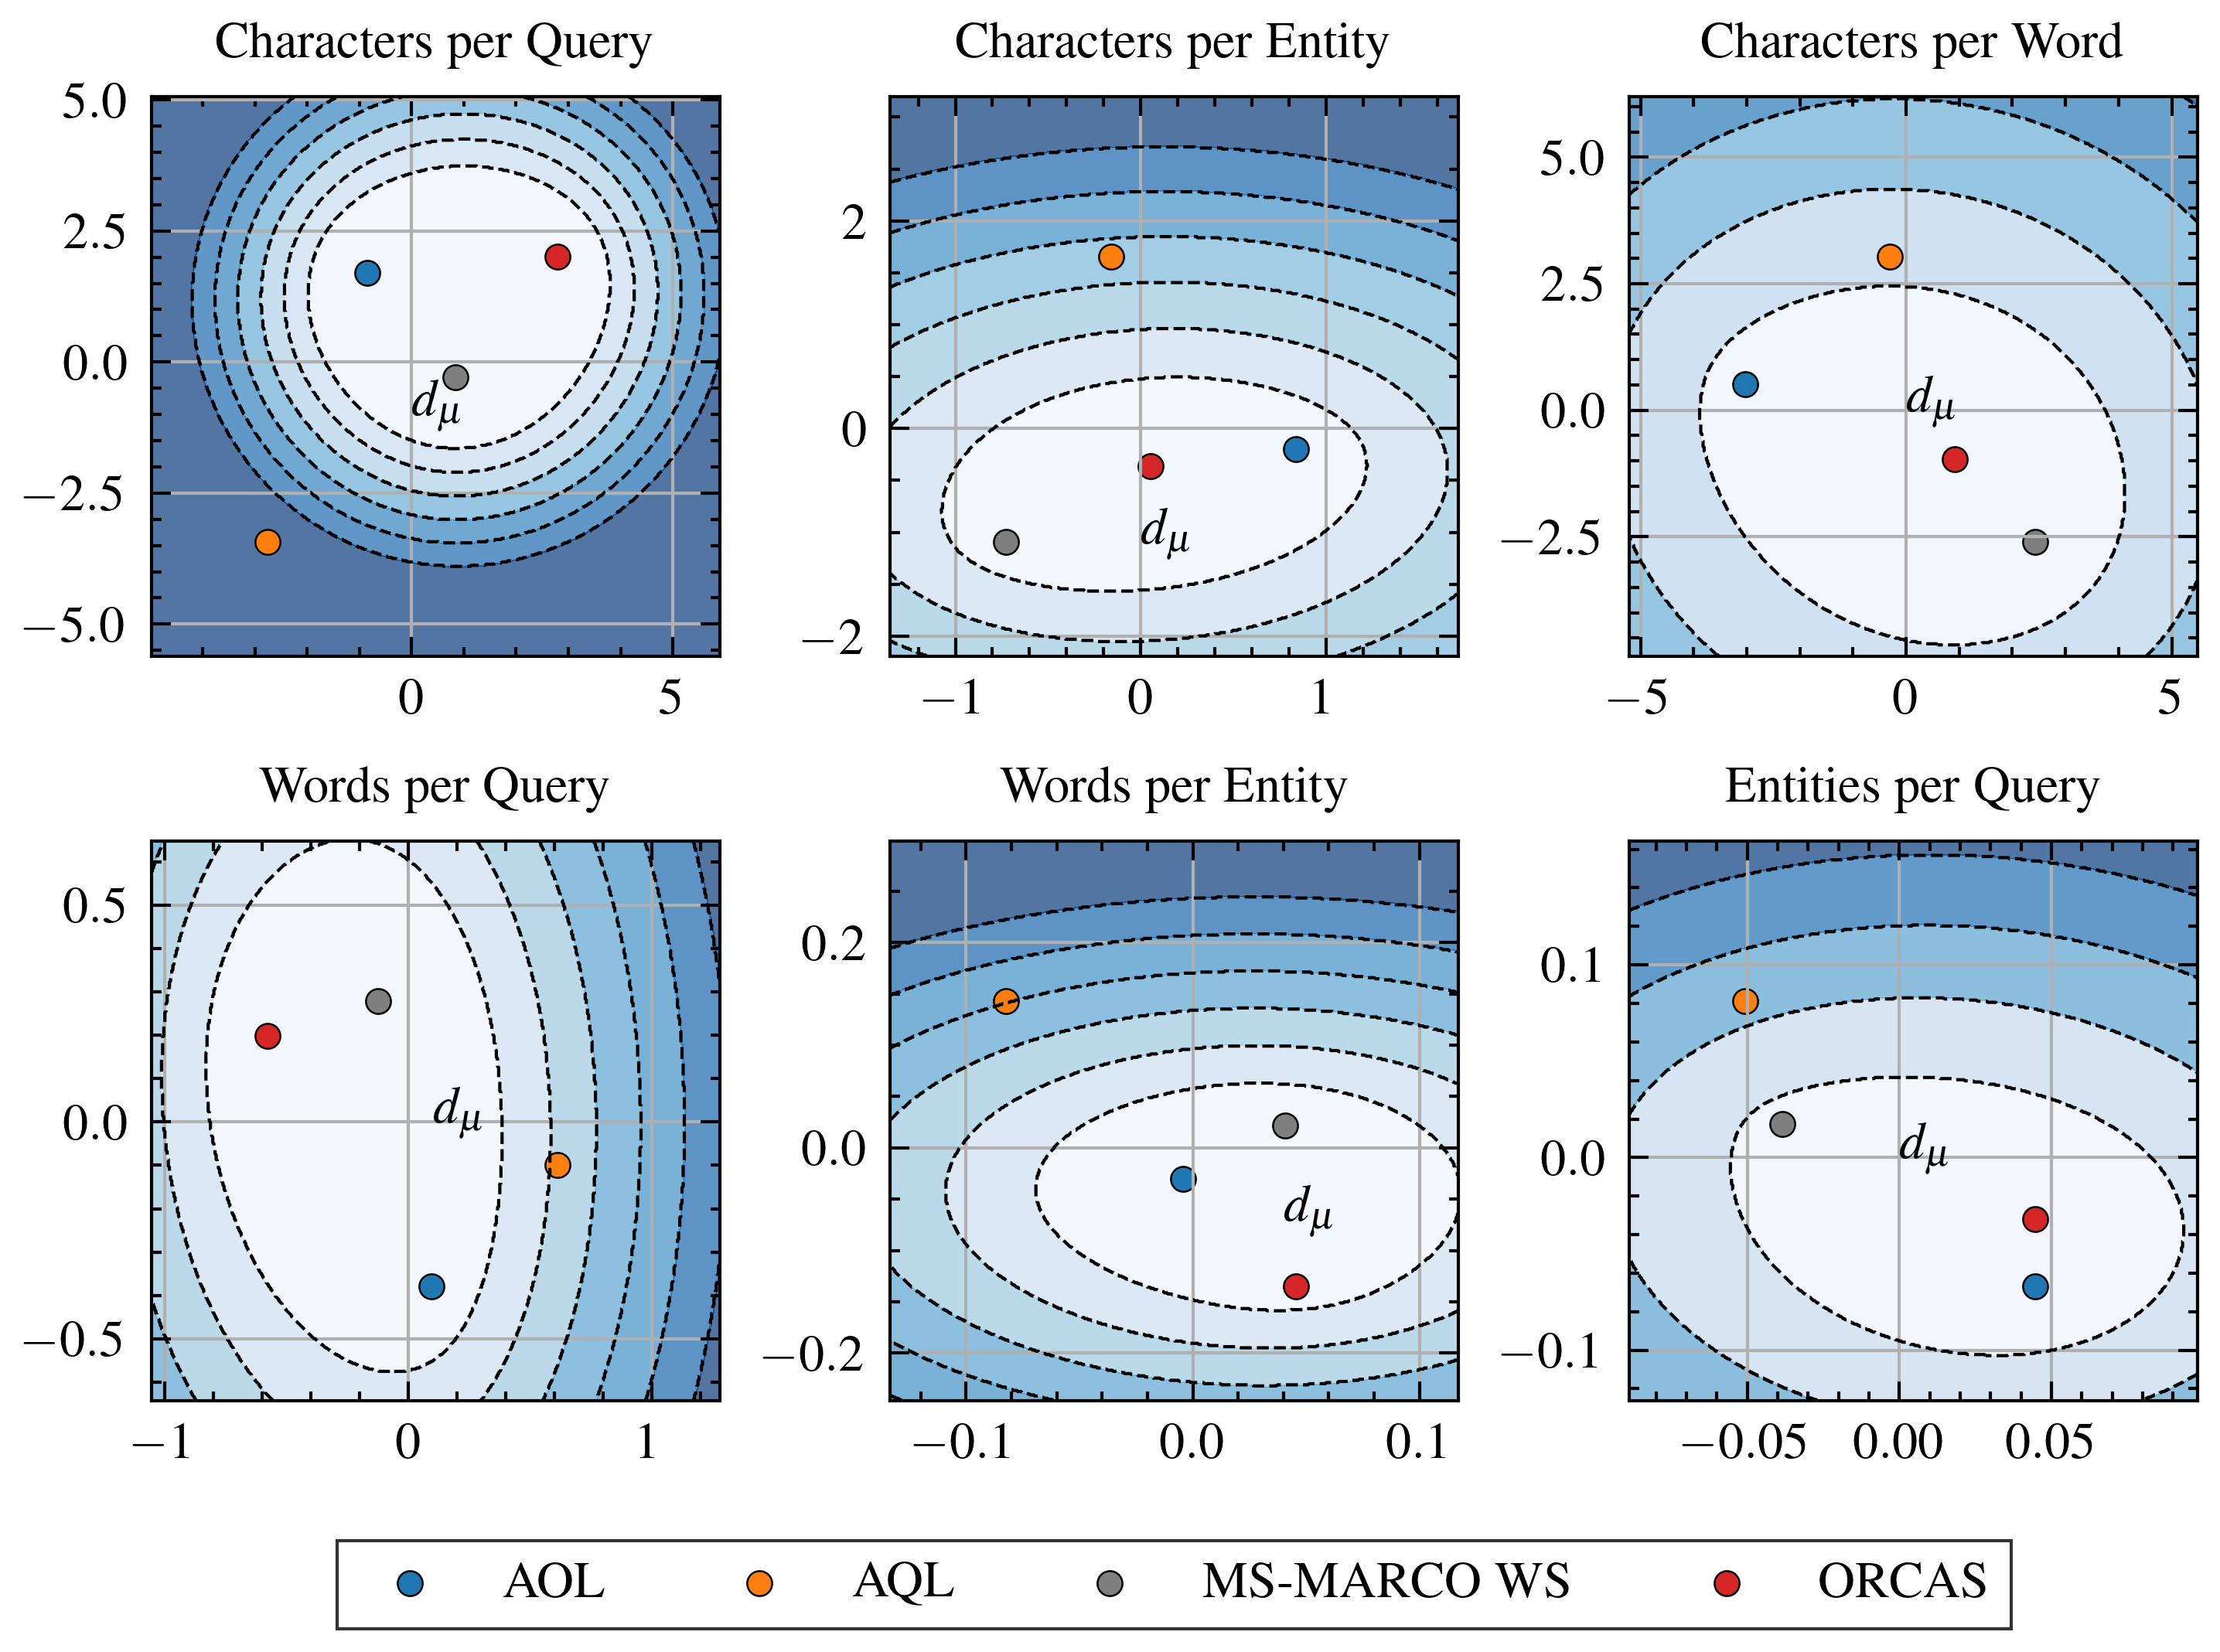

In [63]:
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
from pathlib import Path    
import scienceplots

def avg_dist_notAQL(x,y, point_matrtix):
    dist = 0
    for i in range(len(point_matrtix)):
        if i != 1:
            dist += np.sqrt((x - point_matrtix[i][0])**2 + (y - point_matrtix[i][1])**2)
    dist = dist/3
    # return dist
    # # get the average distance of the points within AOL, ORCAS, MS-MARCO Web Search    
    avg_dist_within = 0
    for i in [(0,2), (0,3), (2,3)]:
        avg_dist_within += np.sqrt((point_matrtix[i[0]][0] - point_matrtix[i[1]][0])**2 + (point_matrtix[i[0]][1] - point_matrtix[i[1]][1])**2)
    avg_dist_within = avg_dist_within/3

    # get the standard deviation of distances within AOL, ORCAS, MS-MARCO Web Search
    std_dist_within = 0
    for i in [(0,2), (0,3), (2,3)]:
        std_dist_within += (np.sqrt((point_matrtix[i[0]][0] - point_matrtix[i[1]][0])**2 + (point_matrtix[i[0]][1] - point_matrtix[i[1]][1])**2) - avg_dist_within)**2
    std_dist_within = np.sqrt(std_dist_within/3) 

    if dist <= avg_dist_within:
        return avg_dist_within
    elif dist > avg_dist_within and dist <= avg_dist_within + std_dist_within:
        return avg_dist_within + std_dist_within
    elif dist > avg_dist_within + std_dist_within and dist <= avg_dist_within + 2 * std_dist_within:
        return avg_dist_within + 2 * std_dist_within
    elif dist > avg_dist_within + 2 * std_dist_within and dist <= avg_dist_within + 3 * std_dist_within:
        return avg_dist_within + 3 * std_dist_within
    elif dist > avg_dist_within + 3 * std_dist_within and dist <= avg_dist_within + 4 * std_dist_within:
        return avg_dist_within + 4 * std_dist_within
    elif dist > avg_dist_within + 4 * std_dist_within and dist <= avg_dist_within + 5 * std_dist_within:
        return avg_dist_within + 5 * std_dist_within
    else: 
        return avg_dist_within + 6 * std_dist_within
        
def avg_dist_within(points):
    dist = 0
    pairs = [(0, 2), (0, 3), (2, 3)]  # Indizes der Punkte AOL, MS-MARCO, ORCAS
    for i, j in pairs:
        dist += np.sqrt((points[i][0] - points[j][0])**2 + (points[i][1] - points[j][1])**2)
    return dist / len(pairs)
def std_within(points):
    dist = 0
    pairs = [(0, 2), (0, 3), (2, 3)]  # Indizes der Punkte AOL, MS-MARCO, ORCAS
    for i, j in pairs:
        dist += (np.sqrt((points[i][0] - points[j][0])**2 + (points[i][1] - points[j][1])**2) - avg_dist_within(points))**2
    return np.sqrt(dist / len(pairs))

# use science style for plots from scienceplots library
plt.style.use(["science", "ieee"])
color =  ['tab:blue', 'tab:orange', 'tab:gray', 'tab:red']

save_vis = True
# save_vis = False

# get meshsize
# mesh_size = 70
mesh_size = 500

num_plots = len(trans_dists)
cols = 3
rows = num_plots//cols
if num_plots % cols != 0:
    rows+=1

textwidth = 5.5129
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio * 0.85


fig,ax = plt.subplots(rows,cols, figsize=(width,height))


# for making the titles
keys = [key for key in trans_dists.keys()]

titles = ["Characters per Query", "Characters per Entity", "Characters per Word", "Words per Query", "Words per Entity", "Entities per Query"]

positions = [[0.0,-1.0], [0.0,-0.6], [0.0,0.0], [-0.4,0.0], [0.04,0.03], [0.0,0.0]]


axes = ax.flatten()
for i in range(len(trans_dists)):
    ax = axes[i]
    ax.set_title(titles[i], fontsize=8)

    points = trans_dists[keys[i]]

    # get the highes and lowest x and y values of the points
    x_min = np.min(points[:,0])
    x_max = np.max(points[:,0])
    y_min = np.min(points[:,1])
    y_max = np.max(points[:,1])

    # scale the extreme values of x and y to get a good boundary for the plot
    # we take the scale of the min range
    range_scale = 0.4
    x_min = x_min - range_scale * (x_max - x_min)
    x_max = x_max + range_scale * (x_max - x_min)
    y_min = y_min - range_scale * (y_max - y_min)
    y_max = y_max + range_scale * (y_max - y_min)

    x = np.linspace(x_min, x_max, mesh_size)
    y = np.linspace(y_min, y_max, mesh_size)

    z = np.array([avg_dist_notAQL(i,j,points) for j in y for i in x])


    X, Y = np.meshgrid(x, y)
    Z = z.reshape(mesh_size, mesh_size)

    avg_dist = avg_dist_within(points)
    std_dist = std_within(points)

    ax.contourf(X.astype(float), Y.astype(float), Z.astype(float), 10, alpha=0.7, cmap = 'Blues', linewidths=0.5, linestyles='solid') #, cmap='Blues' 'OrRd'
    # Add contour lines for the average distance within AOL, MS-MARCO, and ORCAS and the standard deviation 
    contour = ax.contour(X.astype(float), Y.astype(float), Z.astype(float), levels=[avg_dist, avg_dist+std_dist, avg_dist+2*std_dist, avg_dist+3*std_dist, avg_dist+4*std_dist, avg_dist+5*std_dist], colors='black', linewidths=0.5, linestyles='dashed')

    # Label the contour lines with descriptive text
    text = ["$d_{{\mu}}$", "$d_{{\mu}} + \sigma$", "$d_{{\mu}} + 2 \sigma$"]
    for j, level in enumerate(contour.levels):
        # Find the position for the label (e.g., the midpoint of the contour line)
        idx = np.where(Z == level)
        if len(idx[0]) > 0:
            if j == 0:
                if titles[i] == "Characters per Entity":
                    x_pos = positions[i][0] 
                    y_pos = positions[i][1]-0.5
                elif titles[i] == "Words per Query":
                    x_pos = positions[i][0] +0.5
                    y_pos = positions[i][1]
                elif titles[i] == "Words per Entity":
                    x_pos = positions[i][0] 
                    y_pos = positions[i][1] -0.1
                else:
                    x_pos = positions[i][0] 
                    y_pos = positions[i][1]
                ax.text(x_pos, y_pos, text[j] , fontsize=8, color='black')

    labels = [name.upper() for name in names]
    labels[2] = "MS-MARCO WS"
    # plot 3d scatter plot
    for j in range(len(points)):
        ax.scatter(points[j][0], points[j][1], c=color[j], label=labels[j], s=15, edgecolor='black', linewidth=0.3)

    ax.grid(True)
    

handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.03), fancybox=False, ncol=len(names),edgecolor="black", frameon=True).get_frame().set_linewidth(0.5)

plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.33, wspace=0.3)
plt.show()

base_path = "/home/benjamin/studium/masterarbeit/thesis-schneg/plots/"

vis_dir = Path(f"{base_path}Wasserstein-Distances-lengths-2d-contour")
if not vis_dir.exists() and save_vis:
        vis_dir.mkdir(parents=True)

if not vis_dir.exists() and save_vis:
        vis_dir.mkdir(parents=True)

if save_vis:
    fig.savefig(vis_dir.joinpath("all.pdf"), format='pdf')

In [14]:
for key,val in trans_dists.items():
    print(key)
    print(val)


character-count-frequencies-queries
[[ 1.66615017 -0.95723085  0.3940451 ]
 [-3.42421249 -2.45337412 -1.20383152]
 [-0.24483284  0.68136043  0.79681224]
 [ 2.00289516  2.72924454  0.01297418]]
character-count-frequencies-named-entities
[[ 0.67685749  0.47392307  0.26289098]
 [-1.26969281  0.13446073  1.07301775]
 [ 0.37759632 -0.67517238 -1.05387009]
 [ 0.215239    0.06678857 -0.28203864]]
character-count-frequencies-words
[[-1.80451246 -2.33895448 -0.85063394]
 [-1.10170736 -1.17949032  2.56341593]
 [ 2.45976368  2.29309499 -1.08138475]
 [ 0.44645614  1.22534981 -0.63139724]]
word-count-frequencies-queries
[[ 0.23458211 -0.31756215  0.01470728]
 [ 0.14068163 -0.1634973   0.57401679]
 [-0.27044504  0.08691458 -0.13678886]
 [-0.1048187   0.39414487 -0.4519352 ]]
word-count-frequencies-named-entities
[[ 0.01303709 -0.03174606  0.01390489]
 [ 0.05493986  0.12682035 -0.08842325]
 [-0.02974268 -0.01911209 -0.03740094]
 [-0.03823427 -0.0759622   0.11191929]]
entity-count-frequencies-queries


To visualize the distances in 2D, we apply the [MDS-transformation](https://en.wikipedia.org/wiki/Multidimensional_scaling) on the distance matrix, providing us with a configuratiopn of 2D-points that reflect the distance matrix:

character-count-frequencies-queries
character-count-frequencies-named-entities
character-count-frequencies-words
word-count-frequencies-queries
word-count-frequencies-named-entities
entity-count-frequencies-queries


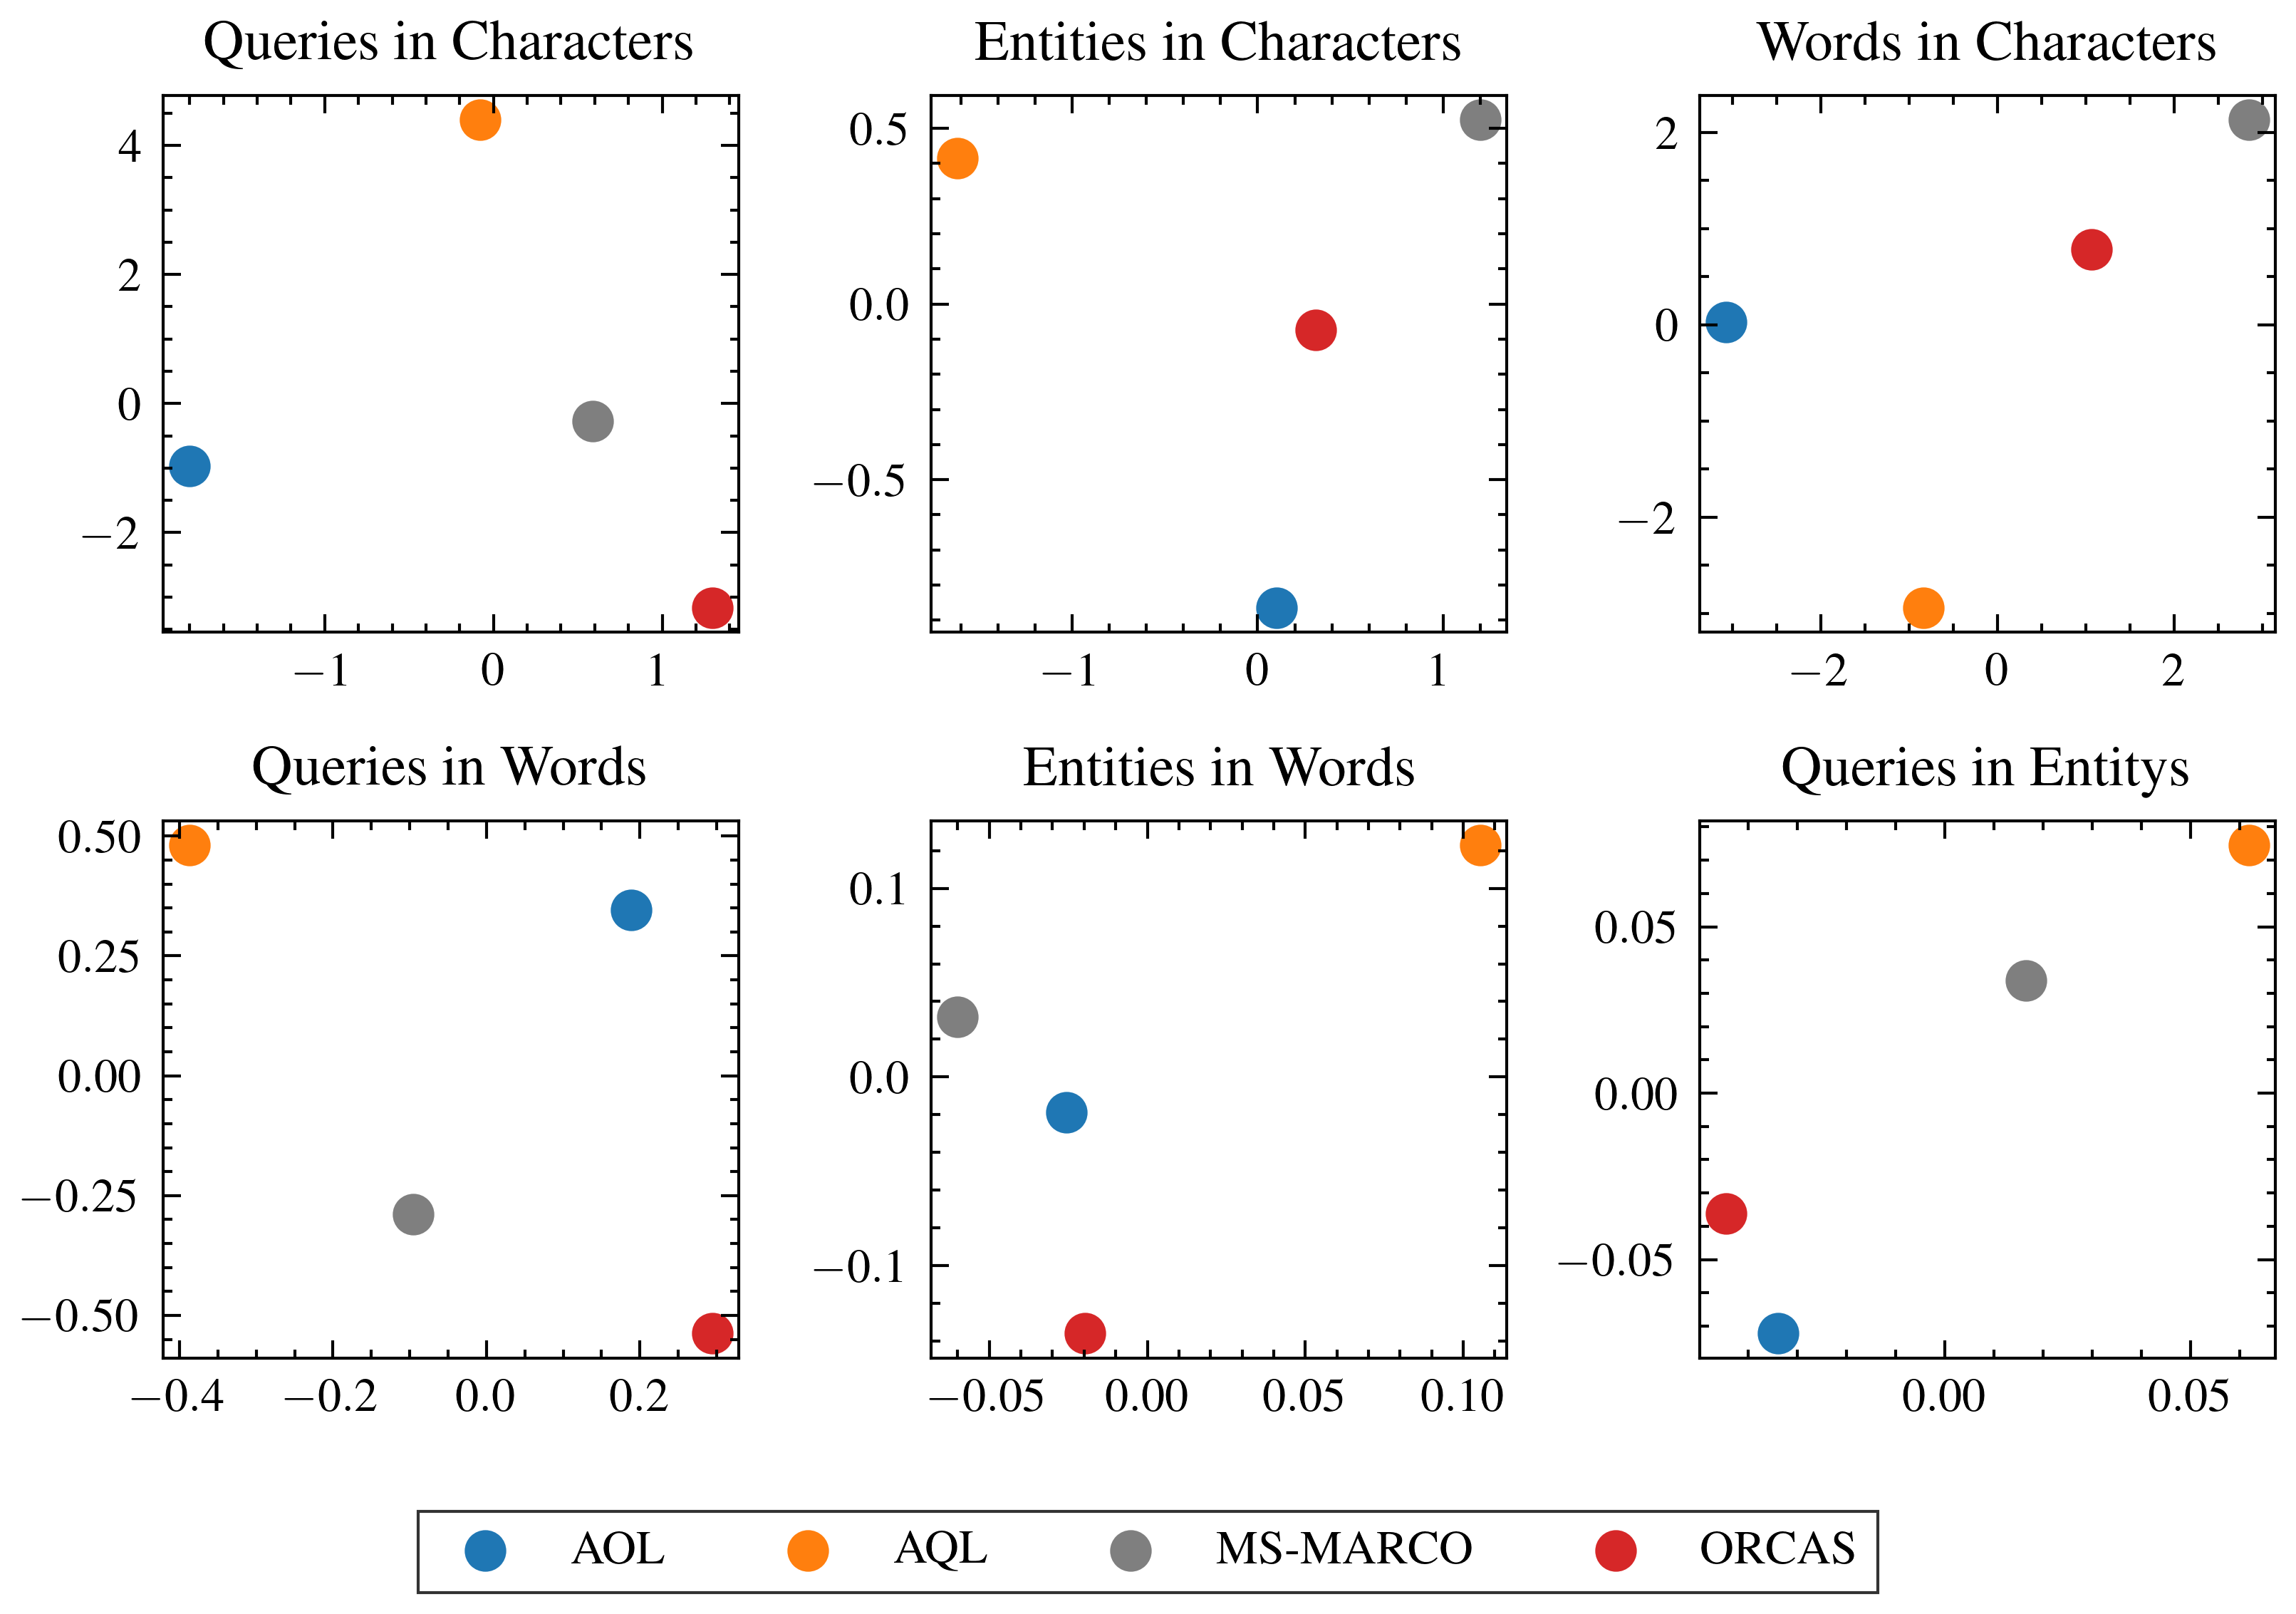

In [ ]:
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
from pathlib import Path    
import scienceplots

# use science style for plots from scienceplots library
plt.style.use(["science", "ieee"])

# save_vis = True
save_vis = False

mds = MDS(n_components=2, dissimilarity='precomputed')
trans_dists = {}
color =  ['tab:blue', 'tab:orange', 'tab:gray', 'tab:red']
for key, value in distances_data.items():
    print(key)
    trans_dists.update({key: mds.fit_transform(value)})

num_plots = len(trans_dists)
cols = 3
rows = num_plots//cols
if num_plots % cols != 0:
    rows+=1

textwidth = 5.5129
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio * 0.85

fig,ax = plt.subplots(rows,cols, figsize=(width,height))

key = [key for key in trans_dists.keys()]

axes = ax.flatten()
for i in range(len(trans_dists)):
    ax = axes[i]
    value = trans_dists[key[i]]
    for j in range(len(value)):
        ax.scatter(value[j][0], value[j][1], c=color[j], label=names[j].upper())

    ax.grid(False)
    ax.set_title(f"{key[i].split('-')[-1].title()} in {key[i].split('-')[0].title()}s")
    # ax.yticks([])
handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=False, ncol=len(names),edgecolor="black", frameon=True).get_frame().set_linewidth(0.5)

plt.tight_layout()
plt.show()

base_path = "/home/benjamin/studium/masterarbeit/thesis-schneg/plots/"

vis_dir = Path(f"{base_path}Wasserstein-Distances-Lengths")
if not vis_dir.exists() and save_vis:
        vis_dir.mkdir(parents=True)

if not vis_dir.exists() and save_vis:
        vis_dir.mkdir(parents=True)

if save_vis:
    fig.savefig(vis_dir.joinpath("all.pdf"), format='pdf')

In [ ]:
for key,val in trans_dists.items():
    print(key)
    print(val)



character-count-frequencies-queries
[[-1.80339684 -0.96514283]
 [-0.08011451  4.40005303]
 [ 0.58654278 -0.26938851]
 [ 1.29696857 -3.16552169]]
character-count-frequencies-named-entities
[[ 0.1024967  -0.8649885 ]
 [-1.61820799  0.41459123]
 [ 1.201885    0.52510976]
 [ 0.31382629 -0.07471248]]
character-count-frequencies-words
[[-3.07702127  0.02899952]
 [-0.83767886 -2.94064674]
 [ 2.84718128  2.13123391]
 [ 1.06751885  0.78041331]]
word-count-frequencies-queries
[[ 0.18834599  0.34514288]
 [-0.38748499  0.48078862]
 [-0.09520124 -0.28824652]
 [ 0.29434024 -0.53768498]]
word-count-frequencies-named-entities
[[-0.02560125 -0.01860758]
 [ 0.10549179  0.12280113]
 [-0.06006841  0.03169654]
 [-0.01982212 -0.13589009]]
entity-count-frequencies-queries
[[-0.03384317 -0.07221472]
 [ 0.06186313  0.07449313]
 [ 0.01648079  0.03385329]
 [-0.04450075 -0.0361317 ]]
